In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

import pandas as pd
pd.set_option('max_colwidth', None)
import os

In [4]:
from utils_printable import printable



abbreviations = {"RAC1P": "RAC", "White alone": "White", "Reference person": "Ref person", \
"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions": "Empl. for-profit-c",\
"Employee of a private not-for-profit, tax-exempt, or charitable organization": "Empl. no-profit-c",
"Self-employed in own not incorporated business, professional practice, or farm": "Self-Empl. not incorp" ,     
"Self-employed in own incorporated business, professional practice or farm": "Self-Empl. incorp" ,
"Local government employee (city, county, etc.)" : "Local gov. Empl. ",
"Federal government employee": "Federal gov.  Empl.",
"California/CA":"CA", "Never married or under 15 years old": "Never married/<15yrs", 
"Biological son or daughter": "Son/daughter", "Regular high school diploma":"HS", \
"Asian alone":"Asian", "1 or more years of college credit":"1+ collage cr",
"Some Other Race alone": "Other", "Bachelor's degree": "Bachelor", "Master's degree": "Master", 
                "Some college, but less than 1 year": "<1y collage",
                "Associate's degree":"Associate",
"Noninstitutionalized group quarters population": "Noninstit. GQs", 
"OCCP=CMM-Software Developers": "OCCP=CMM-SW Dev", 
                 "Professional degree beyond a bachelor's degree": "Prof beyond bachelor"}

# Load data

In [5]:
from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)

In [6]:
from folktables.acs import adult_filter
from folktables import BasicProblem
import numpy as np

feature_names = [ 'AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP',  'RELP', 'WKHP', 'SEX', 'RAC1P' ]

target='PINCP'

ACSIncome_outcome = BasicProblem(
    features=feature_names,
    target=target,
    group='RAC1P',
    preprocess=adult_filter,
)

In [7]:
features, label, group = ACSIncome_outcome.df_to_numpy(acs_data)

In [8]:
continuous_attributes = ['AGEP', 'WKHP']

In [9]:
categorical_attributes = list(set(feature_names)-set(continuous_attributes))

In [10]:
import pandas as pd


df = pd.DataFrame(features, columns=feature_names)
df["income"] = label
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,48500.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,7700.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,17200.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,12000.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,300.0


# Remap columns

From label encoding to interpretable notation: e.g., 0, 1 to "male", "female"

In [11]:
filename = os.path.join(os.path.curdir, "datasets", "ACSPUMS", "PUMS_Data_Dictionary_2018.csv")
df_mappings = pd.read_csv(filename)

In [12]:
remapping_cols = {}

orig_col = "1"
new_col = "Record Type"
cols_i = [orig_col, new_col]

#col_name = "OCCP"
for col_name in categorical_attributes:
    dict_i = df_mappings.loc["VAL"].loc[col_name][cols_i].set_index(orig_col).to_dict()[new_col]
    dict_i = {float(k) if (k not in ["b", "bb", 'bbb', 'bbbb']) else -1 :v for k,v in dict_i.items()}
    remapping_cols[col_name] = dict_i

In [13]:
from copy import deepcopy

df_analysis = deepcopy(df)

for column_name in remapping_cols:
    df_analysis[column_name] = df[column_name].replace(remapping_cols[column_name])

We substituite nan with string "NaN"

In [14]:
for c in df_analysis:
    if df_analysis[c].isna().any():
        print(c)
        df_analysis[c].fillna('NaN', inplace=True)

In [15]:
df_analysis.to_csv(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_dataset_income.csv"), index=False)

In [16]:
continuous_attributes = ['AGEP', 'WKHP']

In [17]:
df_analysis.shape

(195665, 11)

# Taxonomy

In [18]:
df_analysis_proc = deepcopy(df_analysis)

### Occupation

In [19]:
attr = "OCCP"

generalization_dict_tax = {}
generalization_dict_tax[attr] = {x: x.split("-")[0] for x in df_analysis_proc[attr].values if "-" in x}

### Country

We rename some of the columns for vizualization and mapping reasons.

In [20]:
if "POBP" in df_analysis_proc.columns:
    df_analysis_proc["POBP"] = df_analysis_proc["POBP"]\
    .replace({"England":"United Kingdom", 'Scotland': "United Kingdom", \
              "United Kingdom, Not Specified": "United Kingdom",  'Northern Ireland': "United Kingdom",\
               "USSR": "Russia", "Hong Kong": "Hong Kong SAR",
             "Democratic Republic of Congo (Zaire)": 'Democratic Republic of the Congo',
             "Trinidad & Tobago": "Trinidad and Tobago", 'Macedonia':'North Macedonia',
             'Antigua & Barbuda': 'Antigua and Barbuda', \
              'Commonwealth of the Northern Mariana Islands':'Northern Mariana Islands',
             'St. Vincent & the Grenadines': 'St. Vincent and the Grenadines', \
              #simplification
             "Azores Islands": "Portugal"})

In [21]:
# https://statisticstimes.com/geography/countries-by-continents.php
df_taxonomy_country = pd.read_csv("country_hierarchies.csv", header=None, index_col=0)

df_taxonomy_country.columns=["Country or Area","ISO-alpha3 Code", "M49 Code", "Region 1", "Region 2", "Continent"]

df_taxonomy_country["Country or Area"] = df_taxonomy_country["Country or Area"].replace({
    "Viet Nam":"Vietnam", "Bolivia (Plurinational State of)": "Bolivia" ,\
      "Russian Federation": "Russia",'Iran (Islamic Republic of)': 'Iran', \
    "Lao People's Democratic Republic": "Laos", 'Syrian Arab Republic': "Syria", 
    'Venezuela (Bolivarian Republic of)': "Venezuela",
    "Republic of Moldova": "Moldova", "Czechia": "Czech Republic",
        'United Republic of Tanzania': "Tanzania", 'Côte d’Ivoire': "Ivory Coast",
        'United States Virgin Islands': 'US Virgin Islands', 'Saint Lucia': 'St. Lucia', 
    'Saint Kitts and Nevis': 'St. Kitts-Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    "United Kingdom of Great Britain and Northern Ireland" : "United Kingdom",\
    "China, Hong Kong Special Administrative Region" : "Hong Kong SAR"
})


g_hierarchy = {}
target_cols = ["Country or Area", "Region 1", "Continent"]
for i, row in df_taxonomy_country.iterrows():
    levels = [col for col in target_cols if pd.notnull(row[col])]
    
    for l in range(len(levels)-1):
        tax_c, tax_p = row[levels[l]], row[levels[l+1]]
        # If already exist but the value is different
        if "Korea" in tax_c:
            tax_c = "Korea"
        
        if tax_c in g_hierarchy and tax_p!=g_hierarchy[tax_c]:
            print(row)
            raise ValueError()
        if tax_c == tax_p:
            continue
        g_hierarchy[tax_c] = tax_p
attr = 'POBP'
#g_hierarchy = {}
g_hierarchy.update({"North America": "America", 
 "South America": "America", 
 "Americas, Not Specified" : "America", 
"Other Europe, Not Specified": "Europe",
"Eastern Africa, Not Specified": "Africa",
"Other Asia, Not Specified": "Asia",
"South Central Asia, Not Specified": "Asia",
"Caribbean, Not Specified": "North America",
"Other US Island Areas, Oceania, Not Specified, or at Sea": "Oceania",
"Other Africa, Not Specified": "Africa",
"Western Africa, Not Specified": "Africa",
                   "Taiwan" : 'Eastern Asia',
                   'Czechoslovakia':'Eastern Europe', 'Yugoslavia':'Southern Europe'})


In [22]:
generalization_dict_tax_u = deepcopy(g_hierarchy)
delete_values = []
for c, v in df_analysis_proc["POBP"].value_counts().items():
    if c not in g_hierarchy.keys():
        if "/" in c:
            g_hierarchy[c] = "United States of America"
        else:
            delete_values.append(c)

delete_values.append("North America")
delete_values.append("South America")
delete_values.append("Micronesia")

tot_deleted = 0
for c in delete_values:
    print(c, len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c]))
    tot_deleted +=len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c])
print(tot_deleted, round(tot_deleted/len(df_analysis_proc),5))

Asia 54
Europe 23
Africa 18
West Indies 2
North America 0
South America 4
Micronesia 8
109 0.00056


Delete rows for which the detailed information is not available

In [23]:
df_analysis_proc = df_analysis_proc.loc[df_analysis_proc["POBP"].isin(delete_values)==False]

In [24]:
generalization_dict_tax[attr] = generalization_dict_tax_u

# Tree divergence - income - individual

## Tree

In [25]:
metric = "d_outcome"
target = "income"

In [26]:
type_criterion="divergence_criterion"
type_experiment = "one_at_time"
min_sup_divergence = 0.025

In [27]:
min_support_trees = [0.0025, 0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

In [28]:
from tree_discretization_ranking import TreeDiscretization_ranking
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence

max_divergence_dict = {}


for min_support_tree in min_support_trees:

    out = {}
    print(min_support_tree, end = " ")
    
    tree_discr = TreeDiscretization_ranking()



    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analysis_proc,
        type_splitting=type_experiment,
        min_support=min_support_tree,
        metric=metric,
        continuous_attributes= list(continuous_attributes),
        storeTree=True,
        type_criterion = type_criterion,
        minimal_gain = 0.0,
        target_col = target
    )

    
    generalization_dict_all = deepcopy(generalization_dict)
    generalization_dict_all.update(generalization_dict_tax)
    
    from utils_extract_divergence_generalized_ranking import (
        extract_divergence_generalized,
    )

    for apply_generalization in [False, True]:
        if apply_generalization == True:
            pattern_type = "generalized"
        else:
            pattern_type = "base"

        if pattern_type in out:
            continue
            
        FP_fm = extract_divergence_generalized(
            df_analysis_proc,
            discretizations,
            generalization_dict_all,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            target_name = target,
            FPM_type="fpgrowth",
            metrics_divergence = ["d_outcome"],
            type_experiment = type_experiment,
            allow_overalp = False if type_experiment!="all_attributes" else True
        )

        out[pattern_type] = max(FP_fm[metric])
    max_divergence_dict[min_support_tree] = out

0.0025 0.0025 0.005 0.005 0.01 0.01 0.02 0.02 0.025 0.025 0.035 0.035 0.05 0.05 0.075 0.075 0.1 0.1 0.125 0.125 0.15 0.15 0.175 0.175 0.2 0.2 0.25 0.25 0.3 0.3 

In [31]:
max_divergence_dict

{0.0025: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.005: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.01: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.02: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.025: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.035: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.05: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.075: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.1: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.125: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.15: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.175: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.2: {'base': 105256.74307427197, 'generalized': 119340.2092811625},
 0.25: {'base': 105256.74307427197, 'generalized': 115751.94926969381},

# Plot

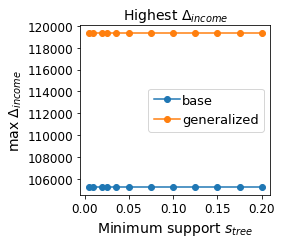

In [33]:
show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]



from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt



metric_name = "Δ_fpr"


vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support_tree: max_divergence_dict[min_support_tree]["base"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}
gen =  { min_support_tree: max_divergence_dict[min_support_tree]["generalized"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))
ax.set_title(r"Highest Δ$_{income}$")


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")

ax.set_ylabel(r"max Δ$_{income}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
plt.legend( fontsize = 13, handletextpad=0.2)



plt.tight_layout();
plt.savefig(f"{outfig_dir}/adult_sensitivity_s_{min_sup_divergence}.pdf");